In [1]:
import numpy as np
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

from tqdm.auto import tqdm

import wandb

import logging
import sys

c:\conda-envs\envs\DLankle\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def setup_logger(name=__name__):
    """
    Sets up a logger that outputs to the console (stdout).
    """
    logger = logging.getLogger(name)
    if not logger.handlers:
        logger.setLevel(logging.INFO)
        handler = logging.StreamHandler(sys.stdout)
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        handler.setFormatter(formatter)
        logger.addHandler(handler)
    return logger

logger = setup_logger()

In [3]:
# Load the dataset
data_folder = "../data"
preped_folder = os.path.join(data_folder, "_preped")

train_data = pd.read_csv(os.path.join(data_folder, 'train_data.csv')).values.tolist()
test_data = pd.read_csv(os.path.join(data_folder, 'test_data.csv')).values.tolist()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to consistent size
    transforms.ToTensor(),           # Convert to tensor [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

x_train = []
y_train = []

for img_name, label in train_data:
    img_path = os.path.join(preped_folder, img_name)
    try:
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img)
        x_train.append(img_tensor)
        y_train.append(label)
    except Exception as e:
        logger.info(f"Error loading {img_name}: {e}")

# Stack into tensors
x_train_tensor = torch.stack(x_train)
logger.info(f"Training images shape: {x_train_tensor.shape}")

# Encode labels to integers
label_to_idx = {label: idx for idx, label in enumerate(np.unique(y_train))}
y_train_encoded = [label_to_idx[label] for label in y_train]
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)

logger.info(f"Training labels shape: {y_train_tensor.shape}")
logger.info(f"Label mapping: {label_to_idx}")

2025-12-11 14:56:33,421 - INFO - Training images shape: torch.Size([241, 3, 224, 224])
2025-12-11 14:56:33,424 - INFO - Training labels shape: torch.Size([241])
2025-12-11 14:56:33,425 - INFO - Label mapping: {np.str_('1_Pronacio'): 0, np.str_('2_Neutralis'): 1, np.str_('3_Szupinacio'): 2}


In [4]:
x_test = []
y_test = []

for img_name, label in test_data:
    img_path = os.path.join(preped_folder, img_name)
    try:
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img)
        x_test.append(img_tensor)
        y_test.append(label)
    except Exception as e:
        logger.info(f"Error loading {img_name}: {e}")

x_test_tensor = torch.stack(x_test)
logger.info(f"Test images shape: {x_test_tensor.shape}")
y_test_encoded = [label_to_idx[label] for label in y_test]
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

logger.info(f"Test labels shape: {y_test_tensor.shape}")

2025-12-11 14:56:44,096 - INFO - Test images shape: torch.Size([49, 3, 224, 224])
2025-12-11 14:56:44,097 - INFO - Test labels shape: torch.Size([49])


In [5]:
if torch.cuda.is_available():
    logger.info(f"CUDA available: {torch.cuda.is_available()}")
    logger.info(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        logger.info(f"\nGPU {i}: {torch.cuda.get_device_name(i)}")
        props = torch.cuda.get_device_properties(i)
        logger.info(f"  Memory: {props.total_memory / 1024**3:.2f} GB")
        logger.info(f"  Compute Capability: {props.major}.{props.minor}")
else:
    logger.info("CUDA not available")

2025-12-11 14:56:44,158 - INFO - CUDA available: True
2025-12-11 14:56:44,160 - INFO - Number of GPUs: 1
2025-12-11 14:56:44,171 - INFO - 
GPU 0: NVIDIA GeForce RTX 4060
2025-12-11 14:56:44,171 - INFO -   Memory: 8.00 GB
2025-12-11 14:56:44,172 - INFO -   Compute Capability: 8.9


In [6]:
batch_size = 32
num_epochs = 15
lr = 0.0001
device = 'cuda' 

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
lr = 0.0001
net0 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 4, kernel_size=3, stride=2, padding=1),   # 256x256 -> 128x128
    torch.nn.ReLU(),
    torch.nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),   # 128x128 -> 64x64
    torch.nn.ReLU(),
    torch.nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),  # 64x64 -> 32x32
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d(1),                                # Global Average Pooling -> 16x1x1
    torch.nn.Flatten(),
    torch.nn.Linear(16, 3)     
).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net0.parameters(), lr=lr)

In [12]:
one_batch = next(iter(train_loader))
images, labels = one_batch
loss_values = []
for epoch in tqdm(range(num_epochs), desc='Training model'):
        net0.train()
        epoch_loss = 0.0
        num_batches = 0
        for images, target_labels in train_loader:
            images = images.to(device)
            target_labels = target_labels.to(device)

            pred_logits = net0(images)
            loss = loss_fn(pred_logits, target_labels)
            epoch_loss += loss.item()
            num_batches += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_values.append(epoch_loss)

Training model: 100%|██████████| 15/15 [00:01<00:00,  9.20it/s]


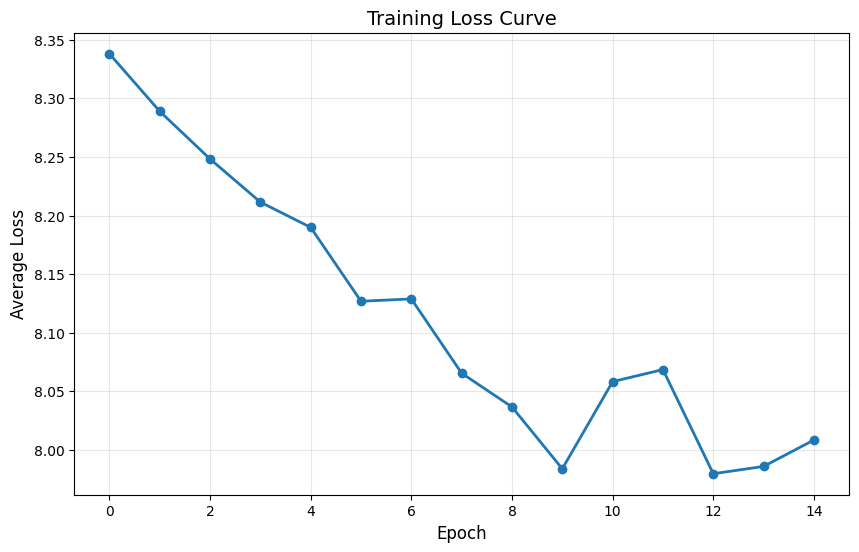

[8.338104128837585, 8.28896701335907, 8.248281598091125, 8.211476564407349, 8.18988311290741, 8.126828134059906, 8.128840625286102, 8.065397441387177, 8.03661048412323, 7.983834087848663, 8.058232128620148, 8.068512976169586, 7.979630291461945, 7.985866904258728, 8.008434474468231]


In [13]:
# Plot training loss curve


plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='o', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.title('Training Loss Curve', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print(loss_values)

In [7]:
# wandb login an init
# Login to wandb with API key
load_dotenv()
wandb.login(key=os.getenv("wandbKey"))

def init_wandb():
    # Initialize wandb project
    wandb.init(
        project="ankle-align",
        config={
            "batch_size": batch_size,
            "num_epochs": num_epochs,
            "learning_rate": lr,
            "architecture": "Custom CNN",
            "dataset": "AnkleAlign",
            "optimizer": "Adam"
        }
    )


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Win 10\_netrc
wandb: Currently logged in as: bencefarkas (bencefarkas-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [8]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                logger.info(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            self.counter = 0


In [9]:
def train_model(network, optimizer, loss_fn, enable_early_stopping=False, patience=5):
    torch.cuda.empty_cache()

    loss_values = []

    if enable_early_stopping:
        early_stopping = EarlyStopping(patience=patience, verbose=True)

    network.train()
    for epoch in tqdm(range(num_epochs), desc='Training model'):
        network.train()
        epoch_loss = 0.0
        num_batches = 0
        for images, target_labels in train_loader:
            images = images.to(device)
            target_labels = target_labels.to(device)

            pred_logits = network(images)
            loss = loss_fn(pred_logits, target_labels)
            epoch_loss += loss.item()
            num_batches += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        avg_train_loss = epoch_loss / num_batches

        if enable_early_stopping:
            network.eval()
            val_loss = 0.0
            val_batches = 0
            correct = 0
            total = 0
            with torch.no_grad():
                for images, target_labels in val_loader:
                    images = images.to(device)
                    target_labels = target_labels.to(device)
                    
                    pred_logits = network(images)
                    loss = loss_fn(pred_logits, target_labels)
                    val_loss += loss.item()
                    val_batches += 1
                    
                    _, predicted = torch.max(pred_logits, 1)
                    total += target_labels.size(0)
                    correct += (predicted == target_labels).sum().item()
            
            avg_val_loss = val_loss / val_batches
            val_accuracy = correct / total

        # Log metrics
        if enable_early_stopping:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy
            })
        else:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_train_loss
            })
        
        
        if enable_early_stopping:
            logger.info(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        else:
            logger.info(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

        # Early stopping check
        if enable_early_stopping:
            early_stopping(avg_val_loss, network)
            if early_stopping.early_stop:
                logger.info("Early stopping triggered")
                network.load_state_dict(early_stopping.best_model)
                break
    
    # Load best model
    if enable_early_stopping and early_stopping.best_model is not None:
        network.load_state_dict(early_stopping.best_model)
        logger.info("Loaded best model weights")

In [10]:
def evaluate_model(network):
    # Training score
    true_labels = y_test_encoded
    predicted_labels = []
    network.eval()
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = network(images)
            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = np.mean([true == pred for true, pred in zip(true_labels, predicted_labels)])
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    logger.info(f"network accuracy: {accuracy * 100:.2f}%")
    logger.info(f"network precision: {precision * 100:.2f}%")
    logger.info(f"network recall: {recall * 100:.2f}%")
    logger.info(f"network F1 score: {f1 * 100:.2f}%")

    logger.info(f"Detailed Classification Report: \n{classification_report(true_labels, predicted_labels)}")

    # Log test metrics
    wandb.log({
        "test_accuracy": accuracy,
        "test_precision": precision,
        "test_recall": recall,
        "test_f1": f1
    })

    wandb.finish()

In [12]:
init_wandb()
train_model(net1, optimizer, loss_fn)
evaluate_model(net1)

Training model:   0%|          | 0/15 [00:00<?, ?it/s]

2025-12-07 11:36:22,859 - INFO - Epoch 1/15, Train Loss: 1.2294


Training model:   7%|▋         | 1/15 [00:00<00:06,  2.03it/s]

2025-12-07 11:36:23,018 - INFO - Epoch 2/15, Train Loss: 0.8834


Training model:  13%|█▎        | 2/15 [00:00<00:03,  3.38it/s]

2025-12-07 11:36:23,173 - INFO - Epoch 3/15, Train Loss: 0.7657


Training model:  20%|██        | 3/15 [00:00<00:02,  4.32it/s]

2025-12-07 11:36:23,331 - INFO - Epoch 4/15, Train Loss: 0.6605


Training model:  27%|██▋       | 4/15 [00:00<00:02,  4.94it/s]

2025-12-07 11:36:23,489 - INFO - Epoch 5/15, Train Loss: 0.5702


Training model:  33%|███▎      | 5/15 [00:01<00:01,  5.37it/s]

2025-12-07 11:36:23,647 - INFO - Epoch 6/15, Train Loss: 0.4690


Training model:  40%|████      | 6/15 [00:01<00:01,  5.65it/s]

2025-12-07 11:36:23,805 - INFO - Epoch 7/15, Train Loss: 0.3919


Training model:  47%|████▋     | 7/15 [00:01<00:01,  5.87it/s]

2025-12-07 11:36:23,964 - INFO - Epoch 8/15, Train Loss: 0.3434


Training model:  53%|█████▎    | 8/15 [00:01<00:01,  5.99it/s]

2025-12-07 11:36:24,120 - INFO - Epoch 9/15, Train Loss: 0.2507


Training model:  60%|██████    | 9/15 [00:01<00:00,  6.11it/s]

2025-12-07 11:36:24,278 - INFO - Epoch 10/15, Train Loss: 0.2309


Training model:  67%|██████▋   | 10/15 [00:01<00:00,  6.18it/s]

2025-12-07 11:36:24,434 - INFO - Epoch 11/15, Train Loss: 0.1960


Training model:  73%|███████▎  | 11/15 [00:02<00:00,  6.24it/s]

2025-12-07 11:36:24,592 - INFO - Epoch 12/15, Train Loss: 0.1623


Training model:  80%|████████  | 12/15 [00:02<00:00,  6.28it/s]

2025-12-07 11:36:24,751 - INFO - Epoch 13/15, Train Loss: 0.1461


Training model:  87%|████████▋ | 13/15 [00:02<00:00,  6.27it/s]

2025-12-07 11:36:24,909 - INFO - Epoch 14/15, Train Loss: 0.1302


Training model:  93%|█████████▎| 14/15 [00:02<00:00,  6.29it/s]

2025-12-07 11:36:25,067 - INFO - Epoch 15/15, Train Loss: 0.0926


Training model: 100%|██████████| 15/15 [00:02<00:00,  5.56it/s]

2025-12-07 11:36:25,111 - INFO - network accuracy: 55.10%



c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


2025-12-07 11:36:25,112 - INFO - network precision: 89.29%
2025-12-07 11:36:25,112 - INFO - network recall: 55.10%
2025-12-07 11:36:25,113 - INFO - network F1 score: 64.22%
2025-12-07 11:36:25,121 - INFO - Detailed Classification Report: 
              precision    recall  f1-score   support

           0       0.25      0.71      0.37         7
           1       1.00      0.52      0.69        42
           2       0.00      0.00      0.00         0

    accuracy                           0.55        49
   macro avg       0.42      0.41      0.35        49
weighted avg       0.89      0.55      0.64        49



c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
wandb: ERROR The nbformat package was not foun

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_loss,█▆▅▄▄▃▃▃▂▂▂▁▁▁▁
epoch,15
test_accuracy,0.55102
test_f1,0.6422
test_precision,0.89286
test_recall,0.55102


In [13]:
# Use train test split, for getting validation metrics during training
x_train_tensor, x_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    x_train_tensor, y_train_tensor, test_size=0.2, random_state=42, stratify=y_train_tensor)

val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 224x224 -> 112x112
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 112x112 -> 56x56
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(64 * 56 * 56, 128),  # 64 channels * 56 * 56 spatial size
    torch.nn.ReLU(),
    torch.nn.Linear(128, 3)  # 3 classes output
).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net1.parameters(), lr=lr)

In [15]:
init_wandb()
train_model(net1, optimizer, loss_fn, enable_early_stopping=True)
evaluate_model(net1)

Training model:   0%|          | 0/15 [00:00<?, ?it/s]

2025-12-07 11:36:28,697 - INFO - Epoch 1/15, Train Loss: 1.2682, Val Loss: 1.1586, Val Acc: 0.4889


Training model:   7%|▋         | 1/15 [00:00<00:06,  2.07it/s]

2025-12-07 11:36:28,857 - INFO - Epoch 2/15, Train Loss: 0.9279, Val Loss: 1.0025, Val Acc: 0.6222


Training model:  13%|█▎        | 2/15 [00:00<00:03,  3.42it/s]

2025-12-07 11:36:29,013 - INFO - Epoch 3/15, Train Loss: 0.7046, Val Loss: 0.9076, Val Acc: 0.5111


Training model:  20%|██        | 3/15 [00:00<00:02,  4.35it/s]

2025-12-07 11:36:29,164 - INFO - Epoch 4/15, Train Loss: 0.5958, Val Loss: 0.9000, Val Acc: 0.6222


Training model:  27%|██▋       | 4/15 [00:00<00:02,  5.03it/s]

2025-12-07 11:36:29,315 - INFO - Epoch 5/15, Train Loss: 0.4855, Val Loss: 0.9177, Val Acc: 0.6000
2025-12-07 11:36:29,316 - INFO - EarlyStopping counter: 1 out of 5


Training model:  33%|███▎      | 5/15 [00:01<00:01,  5.50it/s]

2025-12-07 11:36:29,467 - INFO - Epoch 6/15, Train Loss: 0.3970, Val Loss: 0.9019, Val Acc: 0.5778
2025-12-07 11:36:29,468 - INFO - EarlyStopping counter: 2 out of 5


Training model:  40%|████      | 6/15 [00:01<00:01,  5.83it/s]

2025-12-07 11:36:29,616 - INFO - Epoch 7/15, Train Loss: 0.3015, Val Loss: 0.9526, Val Acc: 0.5778
2025-12-07 11:36:29,617 - INFO - EarlyStopping counter: 3 out of 5


Training model:  47%|████▋     | 7/15 [00:01<00:01,  6.09it/s]

2025-12-07 11:36:29,767 - INFO - Epoch 8/15, Train Loss: 0.2725, Val Loss: 0.9551, Val Acc: 0.6000
2025-12-07 11:36:29,768 - INFO - EarlyStopping counter: 4 out of 5


Training model:  53%|█████▎    | 8/15 [00:01<00:01,  6.25it/s]

2025-12-07 11:36:29,918 - INFO - Epoch 9/15, Train Loss: 0.1988, Val Loss: 0.9690, Val Acc: 0.6000
2025-12-07 11:36:29,918 - INFO - EarlyStopping counter: 5 out of 5
2025-12-07 11:36:29,918 - INFO - Early stopping triggered


Training model:  53%|█████▎    | 8/15 [00:01<00:01,  4.69it/s]

2025-12-07 11:36:29,921 - INFO - Loaded best model weights
2025-12-07 11:36:29,952 - INFO - network accuracy: 44.90%
2025-12-07 11:36:29,952 - INFO - network precision: 90.48%
2025-12-07 11:36:29,953 - INFO - network recall: 44.90%



c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


2025-12-07 11:36:29,953 - INFO - network F1 score: 52.26%
2025-12-07 11:36:29,964 - INFO - Detailed Classification Report: 
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         7
           1       1.00      0.36      0.53        42
           2       0.00      0.00      0.00         0

    accuracy                           0.45        49
   macro avg       0.44      0.45      0.34        49
weighted avg       0.90      0.45      0.52        49



c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
wandb: ERROR The nbformat package was not foun

epoch,▁▂▃▄▅▅▆▇█
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_loss,█▆▄▄▃▂▂▁▁
val_accuracy,▁█▂█▇▆▆▇▇
val_loss,█▄▁▁▁▁▂▂▃
epoch,9
test_accuracy,0.44898
test_f1,0.52256


In [16]:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 224x224 -> 112x112
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 112x112 -> 56x56
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(64 * 56 * 56, 128),  # 64 channels * 56 * 56 spatial size
    torch.nn.ReLU(),
    torch.nn.Linear(128, 3)  # 3 classes output
).to(device)


def init_weights(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

net1.apply(init_weights)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net1.parameters(), lr=lr)

In [17]:
init_wandb()
train_model(net1, optimizer, loss_fn, enable_early_stopping=True)
evaluate_model(net1)
# Weight initialization with Kaiming did not improve the results, probably due to small network, 
# we might get back to it later.

Training model:   0%|          | 0/15 [00:00<?, ?it/s]

2025-12-07 11:36:33,071 - INFO - Epoch 1/15, Train Loss: 5.9141, Val Loss: 4.7751, Val Acc: 0.2444


Training model:   7%|▋         | 1/15 [00:00<00:04,  3.00it/s]

2025-12-07 11:36:33,223 - INFO - Epoch 2/15, Train Loss: 2.8750, Val Loss: 2.8247, Val Acc: 0.5111


Training model:  13%|█▎        | 2/15 [00:00<00:02,  4.42it/s]

2025-12-07 11:36:33,374 - INFO - Epoch 3/15, Train Loss: 1.5192, Val Loss: 1.5318, Val Acc: 0.5556


Training model:  20%|██        | 3/15 [00:00<00:02,  5.21it/s]

2025-12-07 11:36:33,528 - INFO - Epoch 4/15, Train Loss: 0.6288, Val Loss: 1.1715, Val Acc: 0.5556


Training model:  27%|██▋       | 4/15 [00:00<00:01,  5.65it/s]

2025-12-07 11:36:33,680 - INFO - Epoch 5/15, Train Loss: 0.3100, Val Loss: 1.0310, Val Acc: 0.5778


Training model:  33%|███▎      | 5/15 [00:00<00:01,  5.96it/s]

2025-12-07 11:36:33,832 - INFO - Epoch 6/15, Train Loss: 0.1986, Val Loss: 1.0447, Val Acc: 0.6000
2025-12-07 11:36:33,832 - INFO - EarlyStopping counter: 1 out of 5


Training model:  40%|████      | 6/15 [00:01<00:01,  6.15it/s]

2025-12-07 11:36:33,984 - INFO - Epoch 7/15, Train Loss: 0.1361, Val Loss: 1.1592, Val Acc: 0.5556
2025-12-07 11:36:33,985 - INFO - EarlyStopping counter: 2 out of 5


Training model:  47%|████▋     | 7/15 [00:01<00:01,  6.28it/s]

2025-12-07 11:36:34,136 - INFO - Epoch 8/15, Train Loss: 0.1937, Val Loss: 1.1898, Val Acc: 0.5778
2025-12-07 11:36:34,136 - INFO - EarlyStopping counter: 3 out of 5


Training model:  53%|█████▎    | 8/15 [00:01<00:01,  6.38it/s]

2025-12-07 11:36:34,287 - INFO - Epoch 9/15, Train Loss: 0.1720, Val Loss: 1.1864, Val Acc: 0.6222
2025-12-07 11:36:34,288 - INFO - EarlyStopping counter: 4 out of 5


Training model:  60%|██████    | 9/15 [00:01<00:00,  6.45it/s]

2025-12-07 11:36:34,439 - INFO - Epoch 10/15, Train Loss: 0.1204, Val Loss: 1.1758, Val Acc: 0.5333
2025-12-07 11:36:34,440 - INFO - EarlyStopping counter: 5 out of 5
2025-12-07 11:36:34,440 - INFO - Early stopping triggered


Training model:  60%|██████    | 9/15 [00:01<00:01,  5.28it/s]

2025-12-07 11:36:34,444 - INFO - Loaded best model weights
2025-12-07 11:36:34,472 - INFO - network accuracy: 40.82%



c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


2025-12-07 11:36:34,473 - INFO - network precision: 87.14%
2025-12-07 11:36:34,474 - INFO - network recall: 40.82%
2025-12-07 11:36:34,475 - INFO - network F1 score: 55.08%
2025-12-07 11:36:34,483 - INFO - Detailed Classification Report: 
              precision    recall  f1-score   support

           0       0.10      0.14      0.12         7
           1       1.00      0.45      0.62        42
           2       0.00      0.00      0.00         0

    accuracy                           0.41        49
   macro avg       0.37      0.20      0.25        49
weighted avg       0.87      0.41      0.55        49



c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
wandb: ERROR The nbformat package was not foun

epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_loss,█▄▃▂▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇█▇▇█▆
val_loss,█▄▂▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.40816
test_f1,0.55076


In [18]:
net2 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 224x224 -> 112x112
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 112x112 -> 56x56
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 56x56 -> 28x28
    torch.nn.ReLU(),
    torch.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(256 * 14 * 14, 128),  # 256 channels * 14 * 14 spatial size
    torch.nn.ReLU(),
    torch.nn.Linear(128, 3)  # 3 classes output
).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=lr)

In [19]:
init_wandb()
train_model(net2, optimizer, loss_fn, enable_early_stopping=True)
evaluate_model(net2)

Training model:   0%|          | 0/15 [00:00<?, ?it/s]

2025-12-07 11:36:37,326 - INFO - Epoch 1/15, Train Loss: 1.0519, Val Loss: 1.0187, Val Acc: 0.4889


Training model:   7%|▋         | 1/15 [00:00<00:04,  3.27it/s]

2025-12-07 11:36:37,470 - INFO - Epoch 2/15, Train Loss: 0.9819, Val Loss: 0.9923, Val Acc: 0.4889


Training model:  13%|█▎        | 2/15 [00:00<00:02,  4.75it/s]

2025-12-07 11:36:37,627 - INFO - Epoch 3/15, Train Loss: 0.9451, Val Loss: 0.9804, Val Acc: 0.5556


Training model:  20%|██        | 3/15 [00:00<00:02,  5.39it/s]

2025-12-07 11:36:37,767 - INFO - Epoch 4/15, Train Loss: 0.9122, Val Loss: 0.9653, Val Acc: 0.5333


Training model:  27%|██▋       | 4/15 [00:00<00:01,  5.97it/s]

2025-12-07 11:36:37,900 - INFO - Epoch 5/15, Train Loss: 0.8645, Val Loss: 0.9389, Val Acc: 0.5111


Training model:  33%|███▎      | 5/15 [00:00<00:01,  6.45it/s]

2025-12-07 11:36:38,032 - INFO - Epoch 6/15, Train Loss: 0.7870, Val Loss: 0.9512, Val Acc: 0.4889
2025-12-07 11:36:38,033 - INFO - EarlyStopping counter: 1 out of 5


Training model:  40%|████      | 6/15 [00:01<00:01,  6.78it/s]

2025-12-07 11:36:38,166 - INFO - Epoch 7/15, Train Loss: 0.7381, Val Loss: 0.9581, Val Acc: 0.5556
2025-12-07 11:36:38,166 - INFO - EarlyStopping counter: 2 out of 5


Training model:  47%|████▋     | 7/15 [00:01<00:01,  7.00it/s]

2025-12-07 11:36:38,298 - INFO - Epoch 8/15, Train Loss: 0.6777, Val Loss: 0.9647, Val Acc: 0.5111
2025-12-07 11:36:38,298 - INFO - EarlyStopping counter: 3 out of 5


Training model:  53%|█████▎    | 8/15 [00:01<00:00,  7.18it/s]

2025-12-07 11:36:38,430 - INFO - Epoch 9/15, Train Loss: 0.6255, Val Loss: 0.9989, Val Acc: 0.5778
2025-12-07 11:36:38,431 - INFO - EarlyStopping counter: 4 out of 5


Training model:  60%|██████    | 9/15 [00:01<00:00,  7.29it/s]

2025-12-07 11:36:38,563 - INFO - Epoch 10/15, Train Loss: 0.5877, Val Loss: 0.9661, Val Acc: 0.6444
2025-12-07 11:36:38,564 - INFO - EarlyStopping counter: 5 out of 5
2025-12-07 11:36:38,564 - INFO - Early stopping triggered


Training model:  60%|██████    | 9/15 [00:01<00:01,  5.83it/s]

2025-12-07 11:36:38,568 - INFO - Loaded best model weights
2025-12-07 11:36:38,600 - INFO - network accuracy: 24.49%
2025-12-07 11:36:38,601 - INFO - network precision: 88.57%
2025-12-07 11:36:38,601 - INFO - network recall: 24.49%
2025-12-07 11:36:38,602 - INFO - network F1 score: 28.95%



c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


2025-12-07 11:36:38,612 - INFO - Detailed Classification Report: 
              precision    recall  f1-score   support

           0       0.20      0.71      0.31         7
           1       1.00      0.17      0.29        42
           2       0.00      0.00      0.00         0

    accuracy                           0.24        49
   macro avg       0.40      0.29      0.20        49
weighted avg       0.89      0.24      0.29        49



c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_loss,█▇▆▆▅▄▃▂▂▁
val_accuracy,▁▁▄▃▂▁▄▂▅█
val_loss,█▆▅▃▁▂▃▃▆▃
epoch,10
test_accuracy,0.2449
test_f1,0.28954


In [ ]:
lr = 0.0001

net3 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 224x224 -> 112x112
    torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 112x112 -> 56x56
    torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 56x56 -> 28x28
    torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
    torch.nn.Flatten(),
    torch.nn.Linear(256 * 14 * 14, 128),  # 256 channels * 14 * 14 spatial size
    torch.nn.ReLU(),
    torch.nn.Linear(128, 3)  # 3 classes output
).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net3.parameters(), lr=lr)

In [57]:
init_wandb()
train_model(net3, optimizer, loss_fn, enable_early_stopping=True, patience=3)
evaluate_model(net3)

Training model:   0%|          | 0/15 [00:00<?, ?it/s]

2025-12-07 12:39:35,307 - INFO - Epoch 1/15, Train Loss: 1.0397, Val Loss: 1.0252, Val Acc: 0.5778


Training model:   7%|▋         | 1/15 [00:00<00:09,  1.55it/s]

2025-12-07 12:39:35,637 - INFO - Epoch 2/15, Train Loss: 0.9955, Val Loss: 1.0025, Val Acc: 0.4667


Training model:  13%|█▎        | 2/15 [00:00<00:05,  2.18it/s]

2025-12-07 12:39:35,967 - INFO - Epoch 3/15, Train Loss: 0.9514, Val Loss: 0.9884, Val Acc: 0.5556


Training model:  20%|██        | 3/15 [00:01<00:04,  2.50it/s]

2025-12-07 12:39:36,327 - INFO - Epoch 4/15, Train Loss: 0.9066, Val Loss: 0.9759, Val Acc: 0.5556


Training model:  27%|██▋       | 4/15 [00:01<00:04,  2.60it/s]

2025-12-07 12:39:36,653 - INFO - Epoch 5/15, Train Loss: 0.8498, Val Loss: 0.9809, Val Acc: 0.5778
2025-12-07 12:39:36,654 - INFO - EarlyStopping counter: 1 out of 3


Training model:  33%|███▎      | 5/15 [00:01<00:03,  2.75it/s]

2025-12-07 12:39:36,979 - INFO - Epoch 6/15, Train Loss: 0.7774, Val Loss: 1.0047, Val Acc: 0.5333
2025-12-07 12:39:36,980 - INFO - EarlyStopping counter: 2 out of 3


Training model:  40%|████      | 6/15 [00:02<00:03,  2.85it/s]

2025-12-07 12:39:37,341 - INFO - Epoch 7/15, Train Loss: 0.6596, Val Loss: 1.0538, Val Acc: 0.5778
2025-12-07 12:39:37,342 - INFO - EarlyStopping counter: 3 out of 3
2025-12-07 12:39:37,342 - INFO - Early stopping triggered


Training model:  40%|████      | 6/15 [00:02<00:04,  2.24it/s]

2025-12-07 12:39:37,346 - INFO - Loaded best model weights
2025-12-07 12:39:37,395 - INFO - network accuracy: 55.10%
2025-12-07 12:39:37,395 - INFO - network precision: 89.42%
2025-12-07 12:39:37,396 - INFO - network recall: 55.10%
2025-12-07 12:39:37,397 - INFO - network F1 score: 61.18%
2025-12-07 12:39:37,409 - INFO - Detailed Classification Report: 
              precision    recall  f1-score   support

           0       0.26      1.00      0.41         7
           1       1.00      0.48      0.65        42
           2       0.00      0.00      0.00         0

    accuracy                           0.55        49
   macro avg       0.42      0.49      0.35        49
weighted avg       0.89      0.55      0.61        49




c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\

epoch,▁▂▃▅▆▇█
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_loss,█▇▆▆▅▃▁
val_accuracy,█▁▇▇█▅█
val_loss,▅▃▂▁▁▄█
epoch,7
test_accuracy,0.55102
test_f1,0.61182


In [ ]:
lr = 0.00001

net4 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 224x224 -> 112x112

    torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 112x112 -> 56x56

    torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    torch.nn.BatchNorm2d(128),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 56x56 -> 28x28

    torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    torch.nn.BatchNorm2d(256),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
    
    torch.nn.Flatten(),
    torch.nn.Linear(256 * 14 * 14, 128),  # 256 channels * 14 * 14 spatial size
    torch.nn.BatchNorm1d(128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 3)  # 3 classes output
).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net3.parameters(), lr=lr)

In [53]:
init_wandb()
train_model(net4, optimizer, loss_fn, enable_early_stopping=True, patience=3)
evaluate_model(net4)

Training model:   0%|          | 0/15 [00:00<?, ?it/s]

2025-12-07 12:31:35,712 - INFO - Epoch 1/15, Train Loss: 1.0955, Val Loss: 1.1054, Val Acc: 0.3556


Training model:   7%|▋         | 1/15 [00:00<00:10,  1.38it/s]

2025-12-07 12:31:36,104 - INFO - Epoch 2/15, Train Loss: 1.0736, Val Loss: 1.1018, Val Acc: 0.3556


Training model:  13%|█▎        | 2/15 [00:01<00:06,  1.89it/s]

2025-12-07 12:31:36,539 - INFO - Epoch 3/15, Train Loss: 1.1093, Val Loss: 1.0969, Val Acc: 0.3556


Training model:  20%|██        | 3/15 [00:01<00:05,  2.06it/s]

2025-12-07 12:31:36,939 - INFO - Epoch 4/15, Train Loss: 1.0796, Val Loss: 1.0829, Val Acc: 0.3556


Training model:  27%|██▋       | 4/15 [00:01<00:04,  2.21it/s]

2025-12-07 12:31:37,334 - INFO - Epoch 5/15, Train Loss: 1.0939, Val Loss: 1.0761, Val Acc: 0.3778


Training model:  33%|███▎      | 5/15 [00:02<00:04,  2.32it/s]

2025-12-07 12:31:37,767 - INFO - Epoch 6/15, Train Loss: 1.0883, Val Loss: 1.0906, Val Acc: 0.3556
2025-12-07 12:31:37,768 - INFO - EarlyStopping counter: 1 out of 3


Training model:  40%|████      | 6/15 [00:02<00:03,  2.32it/s]

2025-12-07 12:31:38,162 - INFO - Epoch 7/15, Train Loss: 1.0893, Val Loss: 1.1099, Val Acc: 0.3778
2025-12-07 12:31:38,162 - INFO - EarlyStopping counter: 2 out of 3


Training model:  47%|████▋     | 7/15 [00:03<00:03,  2.38it/s]

2025-12-07 12:31:38,554 - INFO - Epoch 8/15, Train Loss: 1.0819, Val Loss: 1.1255, Val Acc: 0.3778
2025-12-07 12:31:38,554 - INFO - EarlyStopping counter: 3 out of 3
2025-12-07 12:31:38,554 - INFO - Early stopping triggered


Training model:  47%|████▋     | 7/15 [00:03<00:04,  1.96it/s]

2025-12-07 12:31:38,558 - INFO - Loaded best model weights
2025-12-07 12:31:38,648 - INFO - network accuracy: 61.22%
2025-12-07 12:31:38,649 - INFO - network precision: 79.27%
2025-12-07 12:31:38,650 - INFO - network recall: 61.22%
2025-12-07 12:31:38,651 - INFO - network F1 score: 68.97%
2025-12-07 12:31:38,664 - INFO - Detailed Classification Report: 
              precision    recall  f1-score   support

           0       0.11      0.14      0.12         7
           1       0.91      0.69      0.78        42
           2       0.00      0.00      0.00         0

    accuracy                           0.61        49
   macro avg       0.34      0.28      0.30        49
weighted avg       0.79      0.61      0.69        49




c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\conda-envs\envs\DLankle\Lib\site-packages\

epoch,▁▂▃▄▅▆▇█
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_loss,▅▁█▂▅▄▄▃
val_accuracy,▁▁▁▁█▁██
val_loss,▅▅▄▂▁▃▆█
epoch,8
test_accuracy,0.61224
test_f1,0.68967
